In [71]:
import geopandas as gpd
import pandas as pd
from libpysal.weights import Queen
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv, GATConv, GraphConv, TransformerConv
from torch_geometric.nn import global_mean_pool, global_max_pool, global_add_pool
from torch_geometric.nn import BatchNorm, LayerNorm
import math
from torch_geometric.data import Data, DataLoader
import numpy as np
import torch.nn.functional as F
from sklearn.metrics import root_mean_squared_error, mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import torch_geometric
from torch_geometric.explain import Explainer, GNNExplainer

In [72]:
adj = pd.read_excel('adjacency_geografi.xlsx', index_col=0)
province_order = adj.columns.tolist()
for i, province in enumerate(province_order):
    province_order[i] = province.upper()

print(province_order)

['SULAWESI TENGAH', 'SULAWESI BARAT', 'SULAWESI SELATAN', 'PAPUA BARAT', 'GORONTALO', 'RIAU', 'DAERAH ISTIMEWA YOGYAKARTA', 'SUMATERA BARAT', 'DKI JAKARTA', 'MALUKU', 'BENGKULU', 'LAMPUNG', 'PAPUA', 'KEPULAUAN RIAU', 'NUSA TENGGARA BARAT', 'JAMBI', 'BALI', 'JAWA TIMUR', 'SUMATERA UTARA', 'SULAWESI TENGGARA', 'NUSA TENGGARA TIMUR', 'KALIMANTAN SELATAN', 'ACEH', 'KALIMANTAN TENGAH', 'KEPULAUAN BANGKA BELITUNG', 'SUMATERA SELATAN', 'BANTEN', 'SULAWESI UTARA', 'KALIMANTAN UTARA', 'KALIMANTAN TIMUR', 'JAWA TENGAH', 'MALUKU UTARA', 'KALIMANTAN BARAT', 'JAWA BARAT']


In [73]:
df = pd.read_excel('Sorted.xlsx')

years = df['Tahun'].unique()

similarity_matrices = {}

for year in years:
    df_year = df[df['Tahun'] == year].copy()

    df_year.set_index('Provinsi', inplace=True)

    input_feature = df_year.drop(columns=['Unnamed: 0.1', 'Unnamed: 0', 'Tahun', 'Stunting'])

    scaler = MinMaxScaler()

    feature_scaled = scaler.fit_transform(input_feature)

    similarity_matrix = cosine_similarity(feature_scaled)

    similarity_df = pd.DataFrame(similarity_matrix,
                                 index=input_feature.index,
                                 columns=input_feature.index)
    
    similarity_matrices[year] = similarity_df

    similarity_df.to_excel(f"Graf 2018-2023/Similarity_Matrix_for_{year}.xlsx")

In [74]:


def get_edge_index_from_similarity(sim_matrix, threshold=0.85):
    edges = []
    n = sim_matrix.shape[0]
    for i in range(n):
        for j in range(n):
            if i != j and sim_matrix[i, j] >= threshold:
                edges.append([i, j])
    return torch.tensor(edges).t().contiguous()  # shape [2, num_edges]


In [75]:
adj = pd.read_excel('adjacency_geografi.xlsx', index_col=0)

# Buat mapping provinsi
province_list = adj.columns.tolist()
province_to_idx = {prov.upper(): idx for idx, prov in enumerate(province_list)}

# Buat edge_index
edge_index = []

for i, source in enumerate(province_list):
    for j, target in enumerate(province_list):
        if adj.iloc[i, j] == 1:
            edge_index.append([i, j])  # <--- harus pakai i, j dari enumerate (bukan nilai dari file langsung)

edge_index = torch.tensor(edge_index, dtype=torch.long).T  # shape [2, num_edges]

In [76]:
graphs_spatial = []
graphs_similarity = []

for tahun in years:
    # ambil fitur dan target provinsi di tahun ini
    fitur_tahun = df[df['Tahun'] == tahun].drop(columns=['Unnamed: 0.1', 'Unnamed: 0', 'Provinsi', 'Tahun', 'Stunting'])
    target_tahun = df[df['Tahun'] == tahun]['Stunting']
    sim_matrix = similarity_matrices[tahun].values # N x N matrix
    
    x = torch.tensor(fitur_tahun.values, dtype=torch.float)
    y = torch.tensor(target_tahun.values, dtype=torch.float)
    
    # adjacency edge index (tetap)
    edge_index_spatial = torch.tensor(edge_index, dtype=torch.long)  # shape [2, num_edges]
    
    # similarity edge index (dinamis)
    edge_index_sim = get_edge_index_from_similarity(sim_matrix, threshold=0.85)

    # buat 2 graph data terpisah
    data_spatial = Data(x=x, y=y, edge_index=edge_index_spatial)
    data_similarity = Data(x=x, y=y, edge_index=edge_index_sim)

    # simpan
    graphs_spatial.append(data_spatial)
    graphs_similarity.append(data_similarity)


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_8796\628807709.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index_spatial = torch.tensor(edge_index, dtype=torch.long)  # shape [2, num_edges]
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_8796\628807709.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index_spatial = torch.tensor(edge_index, dtype=torch.long)  # shape [2, num_edges]
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_8796\628807709.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index_spatial = torch.te

In [77]:
print(f'Graph Spacial: {graphs_spatial}')

print(f'Graph Similarity: {graphs_similarity}')

Graph Spacial: [Data(x=[34, 8], edge_index=[2, 62], y=[34]), Data(x=[34, 8], edge_index=[2, 62], y=[34]), Data(x=[34, 8], edge_index=[2, 62], y=[34]), Data(x=[34, 8], edge_index=[2, 62], y=[34]), Data(x=[34, 8], edge_index=[2, 62], y=[34]), Data(x=[34, 8], edge_index=[2, 62], y=[34])]
Graph Similarity: [Data(x=[34, 8], edge_index=[2, 906], y=[34]), Data(x=[34, 8], edge_index=[2, 906], y=[34]), Data(x=[34, 8], edge_index=[2, 904], y=[34]), Data(x=[34, 8], edge_index=[2, 968], y=[34]), Data(x=[34, 8], edge_index=[2, 938], y=[34]), Data(x=[34, 8], edge_index=[2, 958], y=[34])]


In [78]:
for year, (g1, g2) in enumerate(zip(graphs_spatial, graphs_similarity)):
    print(f"Tahun {year + 2018}")
    print("Spatial edge max:", g1.edge_index.max().item())
    print("Similarity edge max:", g2.edge_index.max().item())

Tahun 2018
Spatial edge max: 33
Similarity edge max: 33
Tahun 2019
Spatial edge max: 33
Similarity edge max: 33
Tahun 2020
Spatial edge max: 33
Similarity edge max: 33
Tahun 2021
Spatial edge max: 33
Similarity edge max: 33
Tahun 2022
Spatial edge max: 33
Similarity edge max: 33
Tahun 2023
Spatial edge max: 33
Similarity edge max: 33


In [79]:
class DualBranchGNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        
        # Branch 1: Spatial Graph
        self.conv_spatial_1 = SAGEConv(in_channels, hidden_channels)
        self.norm_spatial_1 = torch.nn.LayerNorm(hidden_channels)
        
        self.conv_spatial_2 = SAGEConv(hidden_channels, hidden_channels)
        self.norm_spatial_2 = torch.nn.LayerNorm(hidden_channels)
        
        # Branch 2: Similarity Graph
        self.conv_sim_1 = SAGEConv(in_channels, hidden_channels)
        self.norm_sim_1 = torch.nn.LayerNorm(hidden_channels)
        
        self.conv_sim_2 = SAGEConv(hidden_channels, hidden_channels)
        self.norm_sim_2 = torch.nn.LayerNorm(hidden_channels)
        
        # Output layer
        self.out_layer = torch.nn.Linear(hidden_channels * 2, out_channels)

    def forward(self, data_spatial, data_sim):
        # Spatial branch
        x1 = self.conv_spatial_1(data_spatial.x, data_spatial.edge_index)
        x1 = self.norm_spatial_1(x1)
        x1 = F.relu(x1)
        
        x1 = self.conv_spatial_2(x1, data_spatial.edge_index)
        x1 = self.norm_spatial_2(x1)
        x1 = F.relu(x1)
        
        # Similarity branch
        x2 = self.conv_sim_1(data_sim.x, data_sim.edge_index)
        x2 = self.norm_sim_1(x2)
        x2 = F.relu(x2)
        
        x2 = self.conv_sim_2(x2, data_sim.edge_index)
        x2 = self.norm_sim_2(x2)
        x2 = F.relu(x2)
        
        # Concatenate
        x = torch.cat([x1, x2], dim=1)
        out = self.out_layer(x)
        return out

    def get_embedding(self, data_spatial, data_sim):
        # Spatial branch
        x1 = self.conv_spatial_1(data_spatial.x, data_spatial.edge_index)
        x1 = self.norm_spatial_1(x1)
        x1 = F.relu(x1)
        
        x1 = self.conv_spatial_2(x1, data_spatial.edge_index)
        x1 = self.norm_spatial_2(x1)
        x1 = F.relu(x1)
        
        # Similarity branch
        x2 = self.conv_sim_1(data_sim.x, data_sim.edge_index)
        x2 = self.norm_sim_1(x2)
        x2 = F.relu(x2)
        
        x2 = self.conv_sim_2(x2, data_sim.edge_index)
        x2 = self.norm_sim_2(x2)
        x2 = F.relu(x2)
        
        # Concatenate tanpa output layer
        x = torch.cat([x1, x2], dim=1)  # Ini hasil embedding gabungan
        return x




In [80]:
model = DualBranchGNN(in_channels=8, hidden_channels=256, out_channels=1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
loss_fn = torch.nn.MSELoss()

best_loss = float('inf')
best_model_state = None

for epoch in range(1000):
    model.train()
    total_loss = 0

    for year in range(6):  # 6 tahun
        data_spatial = graphs_spatial[year]
        data_sim = graphs_similarity[year]
        y_true = data_spatial.y.view(-1, 1)  # Target
        
        optimizer.zero_grad()
        out = model(data_spatial, data_sim)
        loss = loss_fn(out, y_true)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()

    # Simpan model jika loss lebih baik
    if total_loss < best_loss:
        best_loss = total_loss
        best_model_state = model.state_dict()  # Save best weights

    if epoch % 100 == 0:
        print(f"Epoch {epoch} - Loss: {total_loss:.4f} {'(BEST)' if total_loss == best_loss else ''}")



Epoch 0 - Loss: 2727.4364 (BEST)
Epoch 100 - Loss: 274.0069 
Epoch 200 - Loss: 204.4168 (BEST)
Epoch 300 - Loss: 144.1132 (BEST)
Epoch 400 - Loss: 143.1950 
Epoch 500 - Loss: 110.0559 
Epoch 600 - Loss: 77.0526 
Epoch 700 - Loss: 71.4630 
Epoch 800 - Loss: 53.5760 
Epoch 900 - Loss: 40.7193 


In [81]:
model.load_state_dict(best_model_state)
model.eval()
all_preds = []
all_targets = []
gnn_embeddings_all = []

with torch.no_grad():
    for spatial_data, sim_data in zip(graphs_spatial, graphs_similarity):
        # Kirim kedua data ke model
        out = model(spatial_data, sim_data)

        embedding = model.get_embedding(spatial_data, sim_data)
        gnn_embeddings_all.append(embedding)

        y_pred = out.squeeze().cpu().numpy()
        y_true = spatial_data.y.squeeze().cpu().numpy()  # atau sim_data.y, sama saja

        all_preds.extend(y_pred)
        all_targets.extend(y_true)


gnn_embeddings_all = torch.cat(gnn_embeddings_all, dim=0)  # [204, hidden_dim*2]
print(gnn_embeddings_all.shape)

for true, pred in zip(all_targets, all_preds):
    print(f'True Value: {round(float(true), 2)}, Predicted: {round(float(pred), 2)}')

torch.Size([204, 512])
True Value: 19.3, Predicted: 18.38
True Value: 19.9, Predicted: 18.13
True Value: 19.6, Predicted: 17.74
True Value: 18.2, Predicted: 17.24
True Value: 24.1, Predicted: 20.23
True Value: 15.6, Predicted: 14.5
True Value: 11.3, Predicted: 11.82
True Value: 16.9, Predicted: 15.09
True Value: 13.2, Predicted: 12.49
True Value: 22.8, Predicted: 21.44
True Value: 12.8, Predicted: 11.83
True Value: 12.9, Predicted: 12.6
True Value: 16.2, Predicted: 22.93
True Value: 11.5, Predicted: 14.08
True Value: 18.8, Predicted: 21.46
True Value: 13.1, Predicted: 12.57
True Value: 12.8, Predicted: 10.82
True Value: 15.2, Predicted: 14.01
True Value: 18.7, Predicted: 16.26
True Value: 19.5, Predicted: 18.91
True Value: 24.5, Predicted: 23.41
True Value: 18.4, Predicted: 16.13
True Value: 20.7, Predicted: 19.06
True Value: 18.5, Predicted: 17.5
True Value: 17.1, Predicted: 19.26
True Value: 12.3, Predicted: 11.29
True Value: 13.6, Predicted: 11.48
True Value: 17.2, Predicted: 14.25


In [82]:

print(f'R2 Score: {r2_score(all_targets, all_preds)}')
print(f'MAE: {mean_absolute_error(all_targets, all_preds)}')
print(f'MSE: {mean_squared_error(all_targets, all_preds)}')

R2 Score: 0.8967924750690216
MAE: 1.60772705078125
MSE: 4.729310512542725


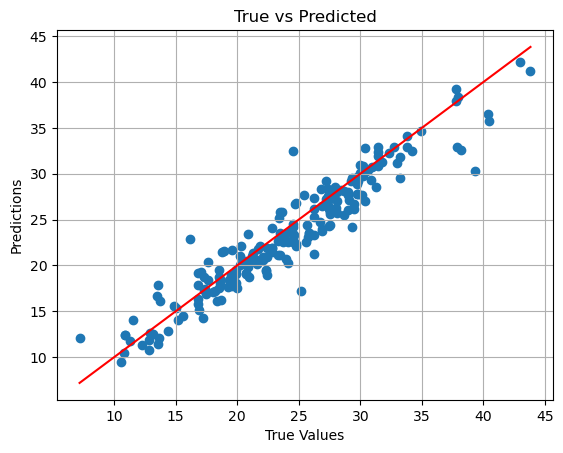

In [83]:


plt.scatter(all_targets, all_preds)
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title("True vs Predicted")
plt.grid(True)
plt.plot([min(all_targets), max(all_targets)],
         [min(all_targets), max(all_targets)], color='red')
plt.show()


In [84]:
nama_fitur = fitur_tahun.columns
print(nama_fitur)

Index(['SD / Sederajat', 'SMP / Sederajat', 'SMA / Sederajat',
       'Prevalensi Ketidakcukupan Konsumsi Pangan (Persen)',
       'Konsumsi Kalori Per Hari Per Kapita',
       'Konsumsi Protein Per Hari Per Kapita', 'Kemisikinan Maret',
       'Akses Sanitasi Bersih'],
      dtype='object')


In [85]:


class SimilarityWrapper(torch.nn.Module):
    def __init__(self, dual_model):
        super().__init__()
        self.model = dual_model

    def forward(self, x, edge_index):
        x2 = self.model.conv_sim_1(x, edge_index)
        x2 = self.model.norm_sim_1(x2)
        x2 = F.relu(x2)

        x2 = self.model.conv_sim_2(x2, edge_index)
        x2 = self.model.norm_sim_2(x2)
        x2 = F.relu(x2)

        return x2


# Pilih tahun dan node yang akan dijelaskan
tahun_ke = 0
node_idx = 30

# Ambil graph similarity dari tahun tersebut
data = graphs_similarity[tahun_ke]

# Bungkus model
wrapper_model = SimilarityWrapper(model)

# Buat explainer
explainer = Explainer(
    model=wrapper_model,
    algorithm=GNNExplainer(epochs=100),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='regression',
        task_level='node',
        return_type='raw',
    )
)

# Jalankan interpretasi node
explanation = explainer(x=data.x, edge_index=data.edge_index, index=node_idx)


print(f'Feature Importance untuk setiap Provinsi')
for i, provinsi in enumerate(province_order):
    print(f'Provinsi: {provinsi}')
    for j, value in enumerate(explanation.node_mask[i]):
        print(f'    Score {nama_fitur[j]}: {round(value.item(), 2)}')
    print()


Feature Importance untuk setiap Provinsi
Provinsi: SULAWESI TENGAH
    Score SD / Sederajat: 0.26
    Score SMP / Sederajat: 0.24
    Score SMA / Sederajat: 0.26
    Score Prevalensi Ketidakcukupan Konsumsi Pangan (Persen): 0.27
    Score Konsumsi Kalori Per Hari Per Kapita: 0.32
    Score Konsumsi Protein Per Hari Per Kapita: 0.27
    Score Kemisikinan Maret: 0.31
    Score Akses Sanitasi Bersih: 0.24

Provinsi: SULAWESI BARAT
    Score SD / Sederajat: 0.3
    Score SMP / Sederajat: 0.27
    Score SMA / Sederajat: 0.3
    Score Prevalensi Ketidakcukupan Konsumsi Pangan (Persen): 0.26
    Score Konsumsi Kalori Per Hari Per Kapita: 0.36
    Score Konsumsi Protein Per Hari Per Kapita: 0.29
    Score Kemisikinan Maret: 0.29
    Score Akses Sanitasi Bersih: 0.27

Provinsi: SULAWESI SELATAN
    Score SD / Sederajat: 0.29
    Score SMP / Sederajat: 0.29
    Score SMA / Sederajat: 0.27
    Score Prevalensi Ketidakcukupan Konsumsi Pangan (Persen): 0.27
    Score Konsumsi Kalori Per Hari Per Ka

In [86]:
edge_scores = explanation.edge_mask
topk = 5  # ambil 5 edge paling penting
topk_indices = edge_scores.topk(topk).indices

for idx in topk_indices:
    source = data.edge_index[0, idx]
    target = data.edge_index[1, idx]
    print(f"Edge {province_order[source.item()]} → {province_order[target.item()]}, Score: {round(edge_scores[idx].item(), 3)}")


Edge NUSA TENGGARA BARAT → JAWA TENGAH, Score: 0.517
Edge KALIMANTAN SELATAN → JAWA TENGAH, Score: 0.494
Edge SUMATERA SELATAN → JAWA TENGAH, Score: 0.458
Edge KALIMANTAN BARAT → SULAWESI BARAT, Score: 0.418
Edge JAWA TIMUR → RIAU, Score: 0.416


In [87]:
from tabpfn import TabPFNRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from sklearn.decomposition import PCA

# Load dan preprocessing
df = pd.read_excel('Sorted.xlsx')
df = df.drop(columns=['Unnamed: 0.1', 'Unnamed: 0', 'Provinsi', 'SMP / Sederajat', 'SMA / Sederajat'])

X = df.drop(columns='Stunting')
y = df['Stunting']

pca = PCA(n_components=32)

x_gnn = gnn_embeddings_all.cpu().numpy()

x_gnn = pca.fit_transform(x_gnn)

print(x_gnn.shape)

scaler = MinMaxScaler()
X = scaler.fit_transform(X)

X_combined = np.concatenate([x_gnn, X], axis=1)


X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y, test_size=0.2, random_state=42
)


(204, 32)


In [88]:
tabfpn = TabPFNRegressor(device='cuda' if torch.cuda.is_available() else 'cpu', ignore_pretraining_limits=True)
tabfpn.fit(X_train, y_train)

rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train, y_train)

RandomForestRegressor()

In [89]:
y_pred = tabfpn.predict(X_test)

print("MSE:", mean_squared_error(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))


MSE: 6.622511710463871
MAE: 1.7459931973713203
R2 Score: 0.849335881767955


In [96]:
y_pred = rf.predict(X_test)

print("MSE:", mean_squared_error(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))


MSE: 13.121335987073161
MAE: 3.0226073170731698
R2 Score: 0.7014856895767867


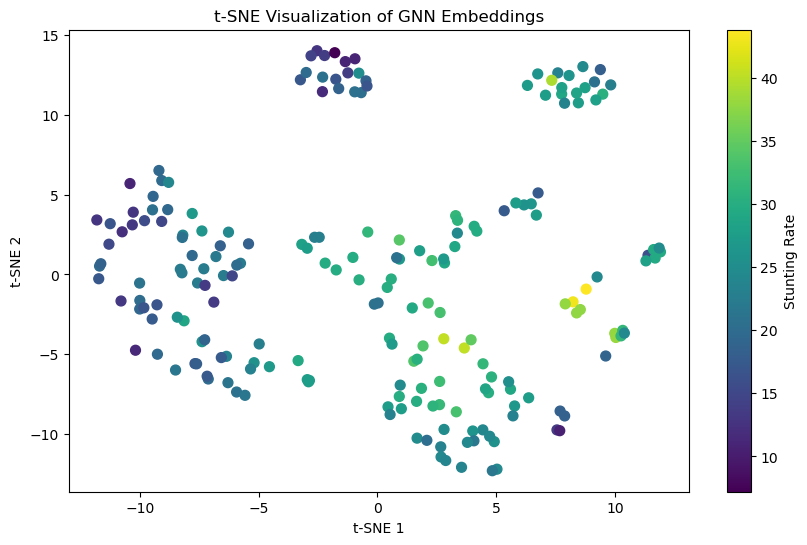

In [90]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Misal X adalah embedding dari GNN (204, 512)
X = gnn_embeddings_all.numpy()

# Jalankan t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X)

# Visualisasi
plt.figure(figsize=(10, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='viridis', s=50)
plt.title("t-SNE Visualization of GNN Embeddings")
plt.colorbar(label='Stunting Rate')
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.show()


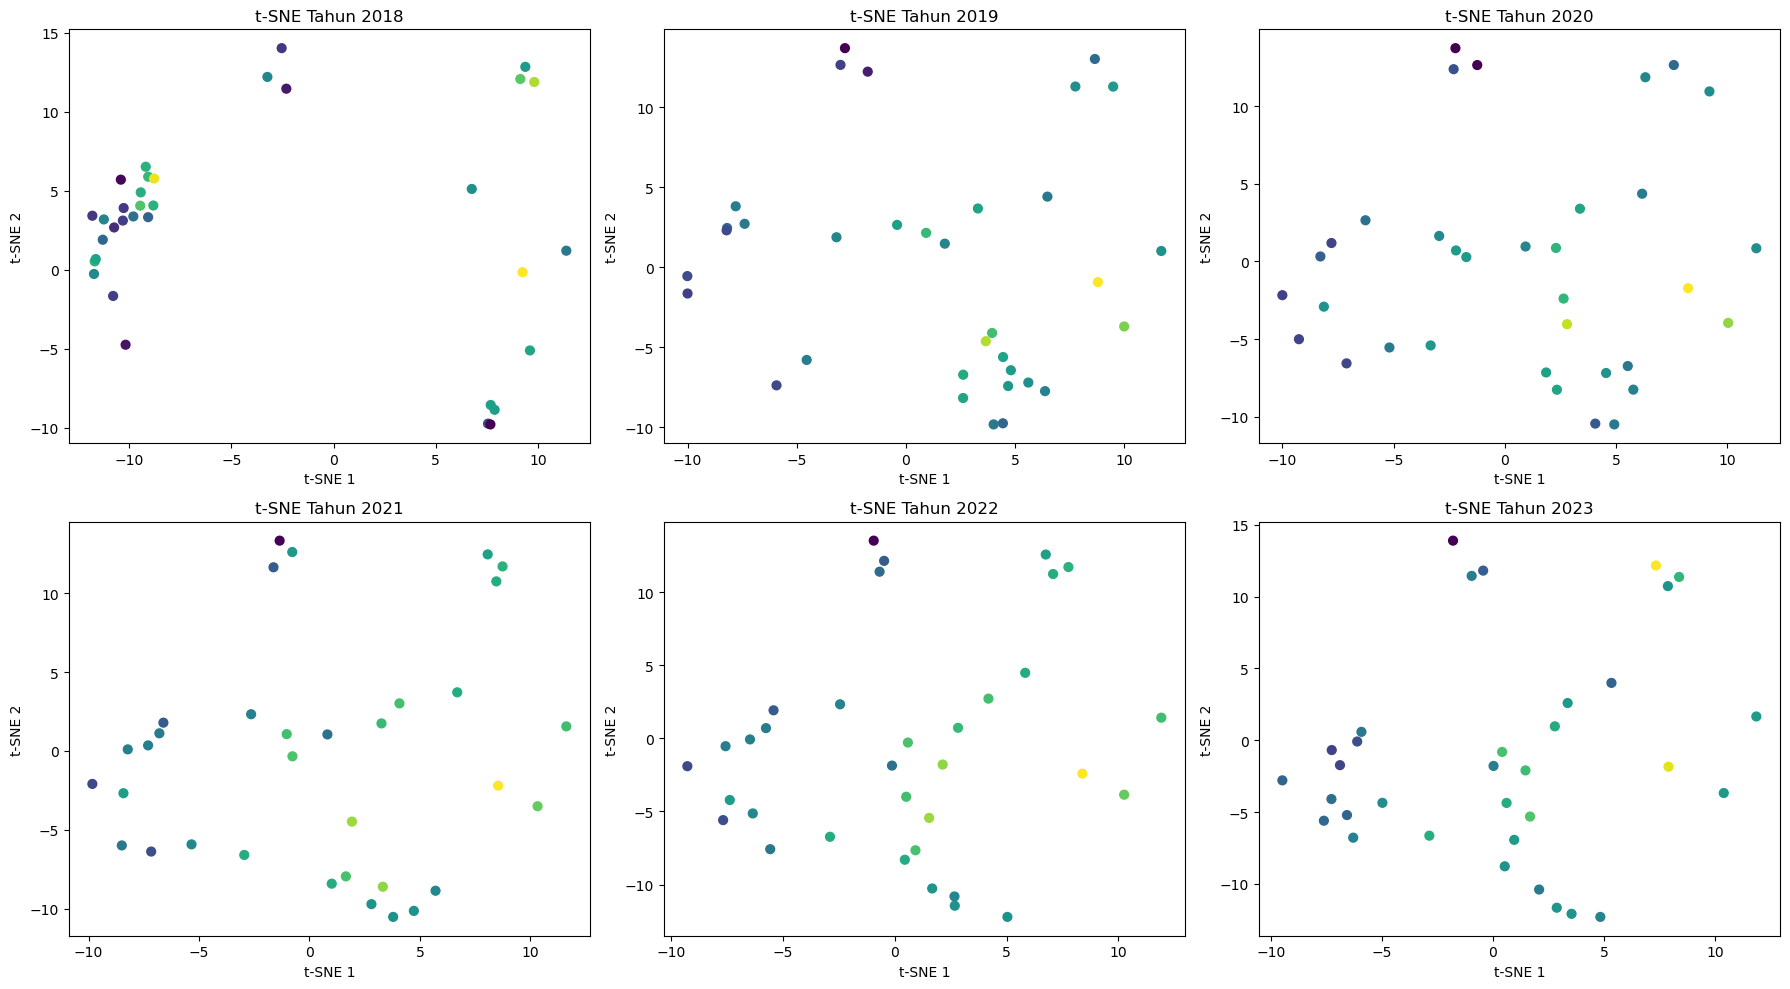

In [95]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Misal data yang sudah kamu punya
# embeddings = gnn_embeddings_all (204, 512)
# stunting_rate_all = (204,)
# tahun_all = (204,)

# Jalankan t-SNE pada seluruh embedding
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(gnn_embeddings_all)

# Dapatkan semua tahun unik
tahun_unik = sorted(np.unique(df['Tahun']))

# Buat subplot
fig, axes = plt.subplots(2, 3, figsize=(18, 10))  # 6 tahun = 2 baris × 3 kolom
axes = axes.flatten()

for i, tahun in enumerate(tahun_unik):
    ax = axes[i]
    idx = (df['Tahun'] == tahun)

    scatter = ax.scatter(
        embeddings_2d[idx, 0],
        embeddings_2d[idx, 1],
        c=y[idx],
        cmap='viridis',
        s=40
    )
    ax.set_title(f"t-SNE Tahun {tahun}")
    ax.set_xlabel("t-SNE 1")
    ax.set_ylabel("t-SNE 2")

# Tambahkan colorbar hanya sekali
plt.tight_layout()
plt.show()
